In [1]:
import numpy as np
import math

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import clear_output

In [2]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Device: cuda


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

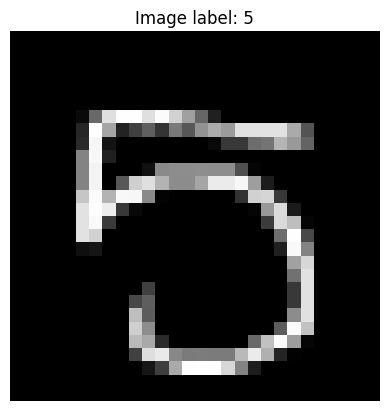

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=128,
    shuffle=True,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=128,
    shuffle=False,
    num_workers=0
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.squeeze(), cmap='gray')
plt.title(f'Image label: {_label}')
plt.axis('off')

In [4]:
class CNN(nn.Module):
  def __init__(self, output=10):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(32*7*7, output)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)

    return x


model = CNN().to(device)

In [5]:
try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'
print('Everything seems fine!')

Everything seems fine!


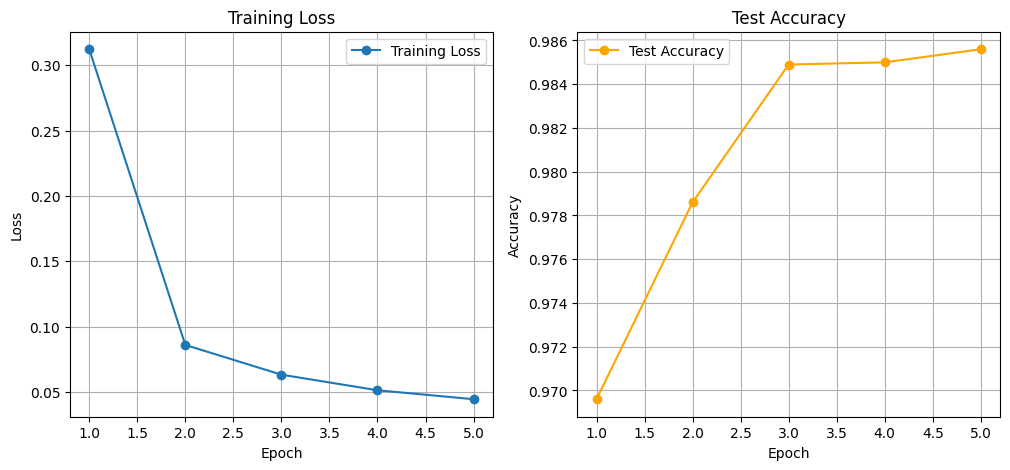

Epoch 5/5
Train Loss: 0.0445 | Test Accuracy: 0.9856 | Best Accuracy: 0.9856
Train finished
Best model loaded succesfully


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

train_losses = []
test_accuracies = []
best_acc = 0.0

for epoch in range(epochs):
    running_loss = 0.0
    for _batch_idx, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_data_loader)

    #accuracy in test set
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

    train_losses.append(epoch_loss)
    test_accuracies.append(test_acc)

    if test_acc > best_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), 'checkpoints/best_model.pth')

    clear_output(wait=True)

    plt.figure(figsize=(12, 5))

    # loss chart
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy chart
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), test_accuracies, marker='o', color='orange', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.show()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Test Accuracy: {test_acc:.4f} | Best Accuracy: {best_acc:.4f}")

print("Train finished")

# Loading best model
if test_acc == best_acc:
  model.eval()
  print("Best model loaded succesfully")
else:
  try:
    model.load_state_dict(torch.load('checkpoints/best_model.pth'))
    model.to(device)
    model.eval()
    print("Best model loaded succesfully")
  except Exception as e:
    print("Something went wrong, please load best model manually")

In [7]:
def visualize_prediction():
  idx = np.random.randint(0, len(test_mnist_data))
  img_tensor, label = test_mnist_data[idx]

  model.eval()
  with torch.no_grad():
    input_tensor = img_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_label = output.argmax(dim=1).item()

  plt.imshow(img_tensor.squeeze(), cmap='gray')
  plt.title(f"True: {label} | Pred: {pred_label}")
  plt.axis('off')
  plt.show()

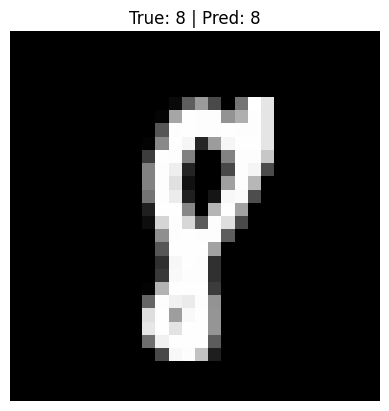

In [8]:
visualize_prediction()

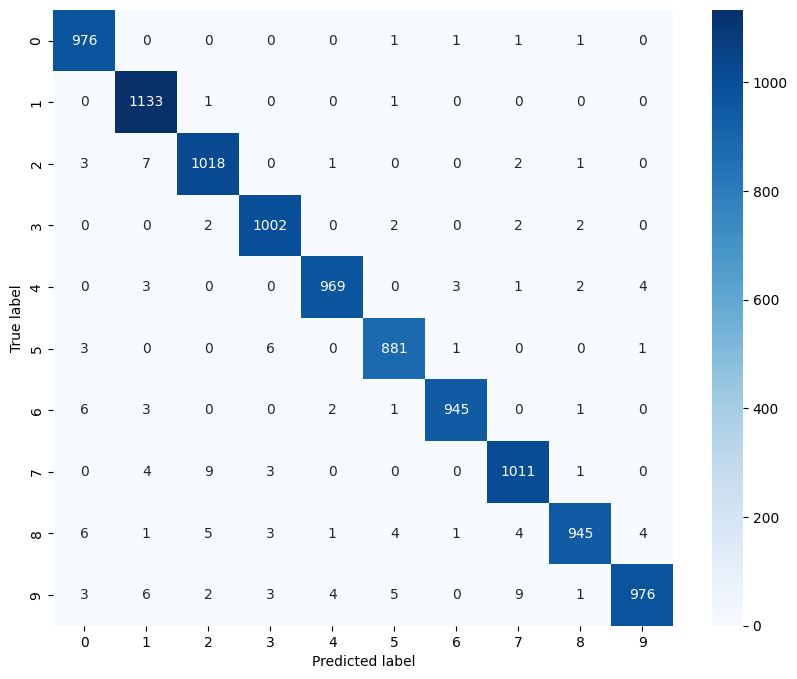

In [9]:
y_true = real_labels.numpy()
y_pred = predicted_labels.numpy()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
report = classification_report(
    y_true,
    y_pred,
    target_names=[str(i) for i in range(10)],
    digits=4,
    output_dict=False
)
print('\n                  --- Classification report ---\n')
print(report)


                  --- Classification report ---

              precision    recall  f1-score   support

           0     0.9789    0.9959    0.9874       980
           1     0.9793    0.9982    0.9887      1135
           2     0.9817    0.9864    0.9841      1032
           3     0.9853    0.9921    0.9887      1010
           4     0.9918    0.9868    0.9893       982
           5     0.9844    0.9877    0.9860       892
           6     0.9937    0.9864    0.9900       958
           7     0.9816    0.9835    0.9825      1028
           8     0.9906    0.9702    0.9803       974
           9     0.9909    0.9673    0.9789      1009

    accuracy                         0.9856     10000
   macro avg     0.9858    0.9855    0.9856     10000
weighted avg     0.9857    0.9856    0.9856     10000



In [11]:
def plot_misclassified_samples(count=9):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for batch in test_data_loader:
            images, labels = batch[0].to(device), batch[1]
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()

            error_idxs = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in error_idxs:
                misclassified.append((images[idx].cpu(), labels[idx].item(), preds[idx].item()))

                if len(misclassified) >= count:
                    break

            if len(misclassified) >= count:
                break

    if not misclassified:
        print("")
        return

    cols = 3
    rows = math.ceil(len(misclassified) / cols)

    plt.figure(figsize=(10, 3.5 * rows))

    for i, (img, true_label, pred_label) in enumerate(misclassified):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label} | Pred: {pred_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

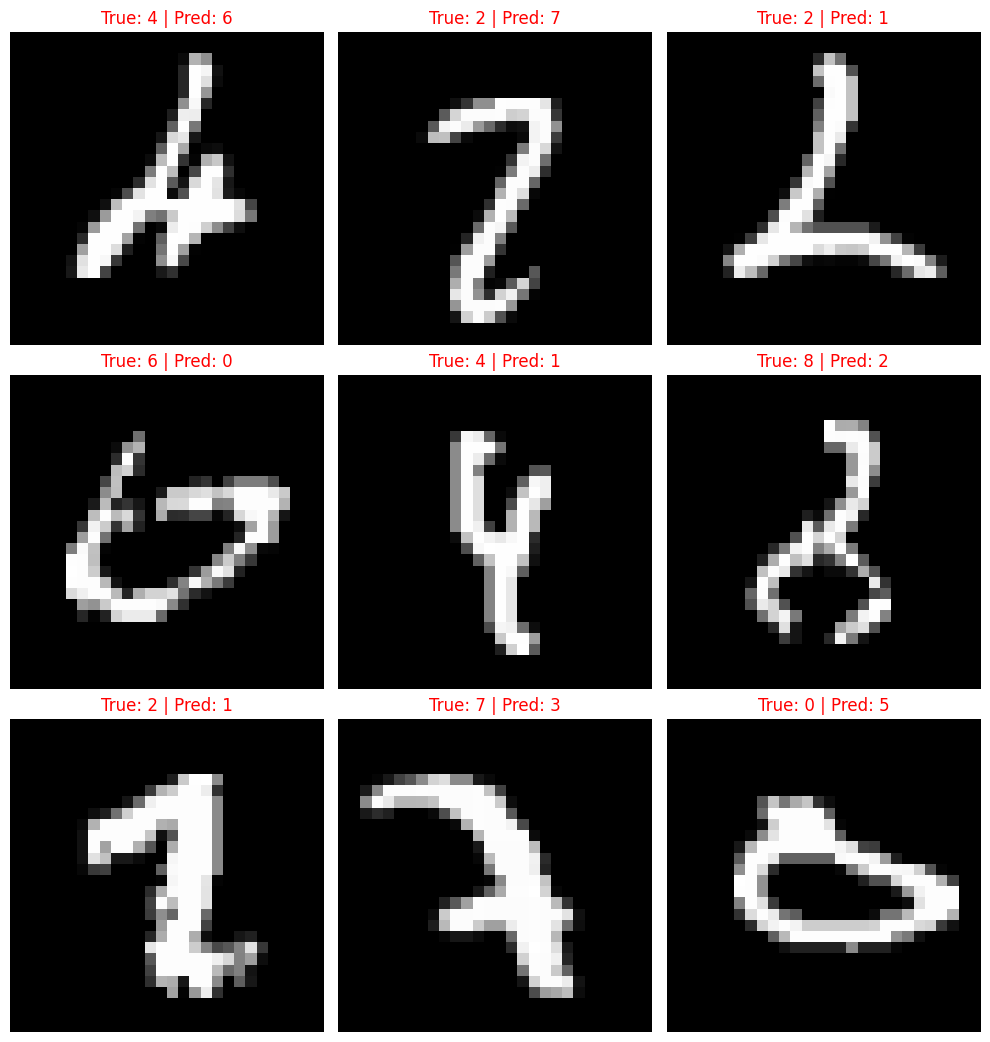

In [12]:
plot_misclassified_samples(count=9)